# VAR 코로나 전후 현황 분석 

## 주가 데이터 다운로드  및 탐색

In [40]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm


import warnings
warnings.filterwarnings("ignore")

In [41]:
#전처리 함수 
def preprocess_(path,  column_, slice='',  encoding=None, header='infer'):

    df = pd.read_csv(path, encoding=encoding, header=header)
    
    if slice:
        df = df[slice]

    df.columns = column_

    if (type(df.iloc[:,1][1])==str):
        df.iloc[:,1] = df.iloc[:,1].apply(lambda x: float(x.replace(',', '')))
        
    df['Date'] = df['Date'].str.replace('[^0-9]', '')
    df['Date'] = df['Date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
    df['Date'] = pd.to_datetime(df['Date'])

    df.sort_values('Date', inplace=True)
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)

    return df

In [42]:
# 데이터 불러오기 
# df_krx = fdr.StockListing('KRX')
# df_krx
# df_krx[df_krx['Name']=='ks200'] #삼성전자 찾기 ['Symbol']
ksp = fdr.DataReader('KS200', '2020-1-19', '2022-3-19')


In [43]:
kspdf = pd.DataFrame(ksp['Close'])
kspdf

,Close
Date,
2020-01-20,305.58
2020-01-21,302.11
2020-01-22,306.08
2020-01-23,302.33
2020-01-28,292.77
...,...
2022-03-14,354.61
2022-03-15,351.03
2022-03-16,356.09


In [44]:
kspdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 534 entries, 2020-01-20 to 2022-03-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   534 non-null    float64
dtypes: float64(1)
memory usage: 8.3 KB


<AxesSubplot:xlabel='Date'>

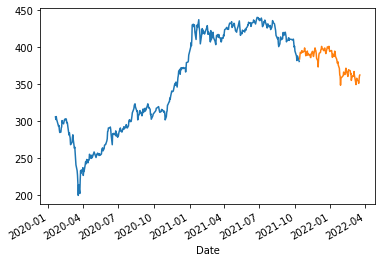

In [45]:
y_train = ksp['Close'][:int(0.8*len(ksp))] #이걸 학습시킨 다음에 
y_test = ksp['Close'][int(0.8*len(ksp)) : ] #이만큼을 아리마로 그어보겠다
y_train.plot()
y_test.plot()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98751D+00    |proj g|=  6.55671D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.557D-06   2.988D+00
  F =   2.9875119599076827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


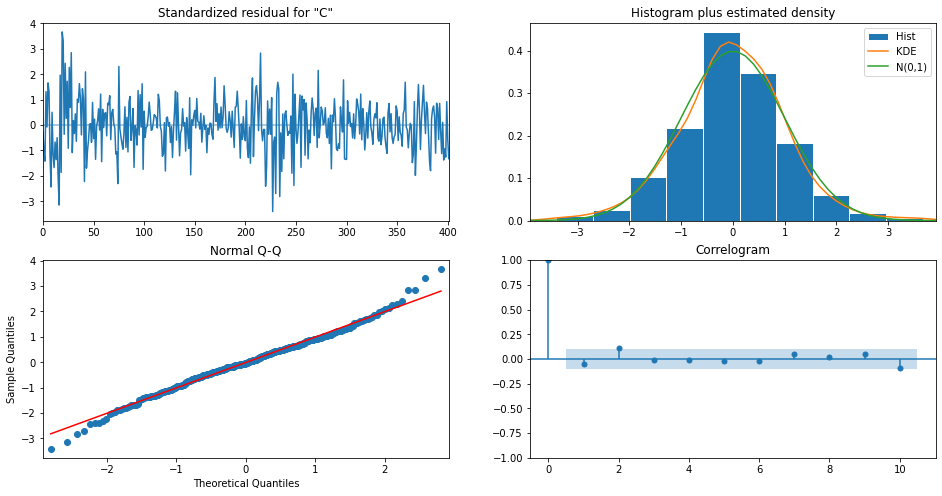

In [46]:
SARIMAMonth = sm.tsa.statespace.SARIMAX(y_train, order=(0, 1, 0), seasonal_order=(1, 1, 0, 12) ,enforce_stationarity=False,enforce_invertibility=False)
SARIMA_results_month = SARIMAMonth.fit()
SARIMA_results_month.plot_diagnostics(figsize=(16, 8))
plt.show()


오류 : Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

=> enforce_stationarity=False 제거 

## ARIMA

(array([18283., 18293., 18300., 18307., 18314., 18322., 18329., 18336.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

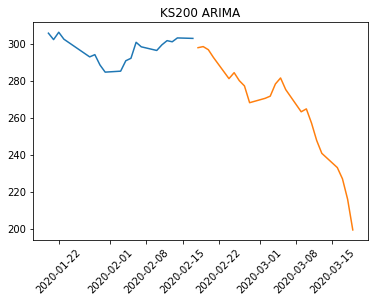

In [47]:
y_train = kspdf.loc['2020-01-19':'2020-02-17']['Close']
y_test = kspdf.loc['2020-02-18':'2020-03-19']['Close'] #dataframe 형태가 아니라 int64 형태로 뽑아야 함 

plt.title('KS200 ARIMA')
plt.plot(y_train)
plt.plot(y_test)
plt.xticks(rotation=45)

In [48]:
#라이브러리 이용해 최적의 차분 차수 찾기 
kpss_diffs = ndiffs(y_train, alpha = 0.05, test= 'kpss', max_d = 6)
adf_diffs = ndiffs(y_train, alpha= 0.05, test= 'adf', max_d =6)
n_diffs = max(kpss_diffs,adf_diffs)

print(f'적정차분차수는 {n_diffs}')

적정차분차수는 3


In [49]:
#파라미터 

#y값은 시계열 array 형태로 써야한다. 1:1 대응밖에 라이브러리 지원을 안한다. 
#차분차수 d는 위에서 나온 1값을 작성한다. 

model = pm.auto_arima(y=y_train,
            d = 3,
            start_p = 0,
            max_p = 10,
            start_q=0,
            max_q=5,
            seasonal = False,
            stepwise = True,
            trace =True)
            #삼성전자 주기가 반복적으로 보이지 않으니 계절성이 없다고 보고 seasonal = fasle 준다. 
            #stepwis는 옵티마이저의 역할을 한다. 
# pqr을 최적의 파라미터를 찾아준다. 그러니까 start 값을 주어 어디부터 찾기 시작할지를 정해준다. 
#max_P는 찾고 마지막으로 찾을 p값 

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=122.117, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=117.228, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=110.164, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=109.299, Time=0.02 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=111.010, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,3,0)(0,0,0)[0] intercept   : AIC=111.286, Time=0.02 sec

Best model:  ARIMA(3,3,0)(0,0,0)[0]          
Total fit time: 0.320 seconds


In [50]:
#함수 제작 

def forcast_one_step():
    fc,conf_int = model.predict(n_periods=1, return_conf_int=True)
    #conf_int 는 신뢰구간이다. 양쪽 이 값 사이에 실제값이 존재할 수 있다.  
    return (fc.tolist()[0],np.asarray(conf_int).tolist()[0]) #리스트로 바꾼다음에 숫자만 뽑아내기 위해 [0]을 출력, ( ) 받은 두개의 인자를 튜플로 묶어서 출력   

#fc 은 예측값, 
# conf_int 은 신뢰구간 

In [51]:
y_test

Date
2020-02-18    297.74
2020-02-19    298.33
2020-02-20    296.65
2020-02-21    292.42
2020-02-24    281.02
2020-02-25    284.24
2020-02-26    279.94
2020-02-27    277.09
2020-02-28    268.02
2020-03-02    270.37
2020-03-03    271.56
2020-03-04    278.13
2020-03-05    281.38
2020-03-06    275.10
2020-03-09    263.11
2020-03-10    264.67
2020-03-11    257.01
2020-03-12    247.62
2020-03-13    240.65
2020-03-16    232.97
2020-03-17    226.89
2020-03-18    215.83
2020-03-19    199.28
Name: Close, dtype: float64

In [52]:
# y_test를 for문으로 계속 하나 받고 업데이트 하나 받고 업데이트 해서 점차적으로 예측할 수 있다. 
forcasst_list = []
y_pred = [] 
pred_upper = []
pred_lower = []

#for y_test를 for문으로 계속 하나 받고 업데이트 하나 받고 업데이트 해서 점차적으로 예측할 수 있다. 
for i in y_test:
    fc, conf = forcast_one_step()
    #튜플로 묶어도 각각으로 출력되나보다. 
    #최저값은 신뢰구간의 가장 작은 값, 최대값은 신뢰구간의 가장 큰 값 으로 잡아서 
    y_pred.append(fc)
    pred_upper.append(conf[1]) #최대 신뢰구간 81948.10571660382 ~ 업데이트 
    pred_lower.append(conf[0]) #최소 신뢰구간 77251.89428339618 ~ 업데이트 

    #계속 이 값을 넣고 업데이트하고 예측하고의 무한반복 
    model.update(i) #그래프로 그리기 위해 리스트로 만든다. 
    # print(model)


In [53]:
y_pred1 = pd.DataFrame({'test':y_test, 'pred':y_pred})
y_pred1
#어제 종가가 오늘 예측 종가가 된다. 최적의 파라미터로 0 1 0으로 찾았기 때문에 한스텝씩 받았기 때문에 전 종가를 오늘 종가로 반영했다. 

,test,pred
Date,,
2020-02-18,297.74,301.447762
2020-02-19,298.33,294.419224
2020-02-20,296.65,295.747611
2020-02-21,292.42,292.152677
2020-02-24,281.02,290.533079
2020-02-25,284.24,272.870907
2020-02-26,279.94,276.708035
2020-02-27,277.09,274.079237
2020-02-28,268.02,277.424619


In [54]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(3, 3, 0)   Log Likelihood                -128.581
Date:                Sun, 01 May 2022   AIC                            265.161
Time:                        00:17:41   BIC                            271.815
Sample:                             0   HQIC                           267.549
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1659      0.186     -6.282      0.000      -1.530      -0.802
ar.L2         -0.9548      0.186     -5.129      0.000      -1.320      -0.590
ar.L3         -0.5161      0.129     -4.013      0.0

ValueError: model.update(i) => could not convert string to float: 'Close'

y_test 값에 close 가 포함되어있었음 왜? 
y_test가 dataframe 형태였기 때문 -> int64로 변경해줌 


- ARIMA 

- 2020년 1월 19일 ~ 2월 17 (train)
- 2020년 2월 18 ~ 3월 19일 (test)
- 예측치 보고 실제 2월 18일 코스피 200과 비교해서 ARIMA가 얼마나 잘 되는지 확인. 
- 코로나가 아니었다면 2월 18일의 데이터는 어땠을까? --> 이 모델이 설명력 있는지 ARIMA 한계 관련 찾아보기 


In [55]:
import plotly.graph_objects as go 
fig = go.Figure([
    go.Scatter(x=y_train.index, y=y_train, name='Train', mode='lines', line=dict(color='royalblue')),
    #테스트 데이터 
    go.Scatter(x=y_test.index, y=y_test, name='Test', mode='lines', line=dict(color='rgba(0,0,30,0.5)')),

    #pred data 
    go.Scatter(x=y_test.index, y=y_pred, name='pred', mode='lines', line=dict(color='red',dash='dot',width=3)),
])

fig.update_layout(height=400, width=1000, title_text="ARIMA 0,1,0")
fig.show()

## VAR 해보기 

 참고 : https://github.com/cheonbi/All-About-Time-Series-Analysis/blob/master/Lecture4_Algorithms_TimeSeries_Linear_Multivariate_KK.ipynb 

 https://sosoeasy.tistory.com/399 

- 기간 2020 2. 18 ~ 2020. 7. 31 (train: test  = 8 : 2)

- 변수 
    - KS200  - 파이넌스데이터리더
    - ~~RSI - 한국변동성지수  ← 코스피 변동성 지수이므로 제거~~
    - 환율
    - 유가 (WTI)
    - VIX - 미국변동성지수
    - 금

In [56]:
#데이터 
y_data= kspdf.loc['2020-02-18':'2020-07-31']
y_train = y_data[:int(0.7*len(y_data))]
y_test = y_data[int(0.7*len(y_data)):]

In [57]:
y_data

,Close
Date,
2020-02-18,297.74
2020-02-19,298.33
2020-02-20,296.65
2020-02-21,292.42
2020-02-24,281.02
...,...
2020-07-27,293.51
2020-07-28,300.13
2020-07-29,301.25


In [58]:
y_train.describe()

,Close
count,80.000000
mean,257.682625
std,22.313512
min,199.280000
25%,245.425000
50%,255.645000
75%,273.667500
max,298.330000


In [59]:
y_test.describe()

,Close
count,35.000000
mean,287.642286
std,7.235454
min,267.950000
25%,282.805000
50%,286.770000
75%,291.920000
max,301.850000


In [60]:
#VIX 지수  'ZG'금 선물 (ICE) #'USD/KRW'달러/원화          
var_list = [['VIX',"VIX"],['USD/KRW','USD/KRW'],['gold','ZG']]
for name, code in var_list:
    globals()[f'Var_{name}'] = pd.DataFrame(fdr.DataReader(code, '2020-02-18', '2020-07-31')['Close']) #반복문으로 변수 생성 및 저장 


In [61]:
globals()['Var_USD/KRW']

,Close
Date,
2020-02-18,1190.95
2020-02-19,1192.50
2020-02-20,1204.71
2020-02-21,1206.91
2020-02-24,1219.08
...,...
2020-07-27,1195.57
2020-07-28,1199.46
2020-07-29,1189.79


In [62]:
# FRED 데이터
#소비자심리지수 (UMCSENT) #M2SL통화 유동량
FRED = fdr.DataReader(['M2SL','UMCSENT'],'2020-02-18','2020-07-31', data_source='fred') 
FRED

,M2SL,UMCSENT
DATE,,
2020-02-01,15458.7,101.0
2020-03-01,15988.6,89.1
2020-04-01,17002.5,71.8
2020-05-01,17835.2,72.3
2020-06-01,18129.3,78.1
2020-07-01,18277.8,72.5


In [63]:
df_list = [y_data,globals()['Var_VIX'], globals()['Var_USD/KRW'], globals()['Var_gold'],FRED]

In [64]:
dd = pd.concat(df_list, #objs속성은 리스트 형태로 데이터프레임을 묶어 
	axis = 1, # 0일 경우 행병합(위아래 합치기) 1일 경우 열병합(좌우로 합치기). Default는 0.
    	join = 'outer', # 'outer'의 경우 outer join, 'inner'의 경우 inner join. Optional.
        ignore_index = False, # True일 경우 기존의 index를 저장하지 않음. Default는 False.
        copy = False, # 복사
        verify_integrity = False # True일 경우 index가 중복되었는 지 확인
        )

In [65]:
dd

,Close,Close,Close,Close,M2SL,UMCSENT
2020-02-01,NaN,NaN,NaN,NaN,15458.7,101.0
2020-02-18,297.74,14.83,1190.95,1657.9,NaN,NaN
2020-02-19,298.33,14.38,1192.50,1666.3,NaN,NaN
2020-02-20,296.65,15.56,1204.71,1674.8,NaN,NaN
2020-02-21,292.42,17.08,1206.91,1703.1,NaN,NaN
...,...,...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9,NaN,NaN
2020-07-28,300.13,25.44,1199.46,2013.2,NaN,NaN
2020-07-29,301.25,24.10,1189.79,NaN,NaN,NaN
2020-07-30,301.85,24.76,1189.62,2014.2,NaN,NaN


In [66]:
dd.columns = ['KS200','VIX','USD/KRW','gold','M2SL','UMCSENT']
dd

,KS200,VIX,USD/KRW,gold,M2SL,UMCSENT
2020-02-01,NaN,NaN,NaN,NaN,15458.7,101.0
2020-02-18,297.74,14.83,1190.95,1657.9,NaN,NaN
2020-02-19,298.33,14.38,1192.50,1666.3,NaN,NaN
2020-02-20,296.65,15.56,1204.71,1674.8,NaN,NaN
2020-02-21,292.42,17.08,1206.91,1703.1,NaN,NaN
...,...,...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9,NaN,NaN
2020-07-28,300.13,25.44,1199.46,2013.2,NaN,NaN
2020-07-29,301.25,24.10,1189.79,NaN,NaN,NaN
2020-07-30,301.85,24.76,1189.62,2014.2,NaN,NaN


In [67]:
dd.describe()

,KS200,VIX,USD/KRW,gold,M2SL,UMCSENT
count,115.000000,117.000000,119.000000,96.000000,6.000000,6.00000
mean,266.800783,36.607179,1213.847395,1763.616667,17115.350000,80.80000
std,23.502080,13.705481,17.107421,98.870569,1176.805722,11.88579
min,199.280000,14.380000,1180.500000,1511.800000,15458.700000,71.80000
25%,252.010000,27.680000,1200.690000,1701.550000,16242.075000,72.35000
50%,268.320000,32.610000,1212.460000,1759.300000,17418.850000,75.30000
75%,286.210000,41.170000,1225.085000,1817.225000,18055.775000,86.35000
max,301.850000,82.690000,1272.500000,2034.400000,18277.800000,101.00000


In [68]:
#결측치 확인
dd.gold.isnull().sum()

25

In [69]:
#결측치는 전날 데이터로 채우기 
dd.fillna(method='pad',inplace=True)

In [70]:
dd

,KS200,VIX,USD/KRW,gold,M2SL,UMCSENT
2020-02-01,NaN,NaN,NaN,NaN,15458.7,101.0
2020-02-18,297.74,14.83,1190.95,1657.9,15458.7,101.0
2020-02-19,298.33,14.38,1192.50,1666.3,15458.7,101.0
2020-02-20,296.65,15.56,1204.71,1674.8,15458.7,101.0
2020-02-21,292.42,17.08,1206.91,1703.1,15458.7,101.0
...,...,...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9,18277.8,72.5
2020-07-28,300.13,25.44,1199.46,2013.2,18277.8,72.5
2020-07-29,301.25,24.10,1189.79,2013.2,18277.8,72.5
2020-07-30,301.85,24.76,1189.62,2014.2,18277.8,72.5


In [71]:
#필요없는 구간 지우기 
dd = dd.loc['2020-02-18':'2020-07-31']
dd

,KS200,VIX,USD/KRW,gold,M2SL,UMCSENT
2020-02-18,297.74,14.83,1190.95,1657.9,15458.7,101.0
2020-02-19,298.33,14.38,1192.50,1666.3,15458.7,101.0
2020-02-20,296.65,15.56,1204.71,1674.8,15458.7,101.0
2020-02-21,292.42,17.08,1206.91,1703.1,15458.7,101.0
2020-02-24,281.02,25.03,1219.08,1730.3,15458.7,101.0
...,...,...,...,...,...,...
2020-07-27,293.51,24.74,1195.57,2004.9,18277.8,72.5
2020-07-28,300.13,25.44,1199.46,2013.2,18277.8,72.5
2020-07-29,301.25,24.10,1189.79,2013.2,18277.8,72.5
2020-07-30,301.85,24.76,1189.62,2014.2,18277.8,72.5


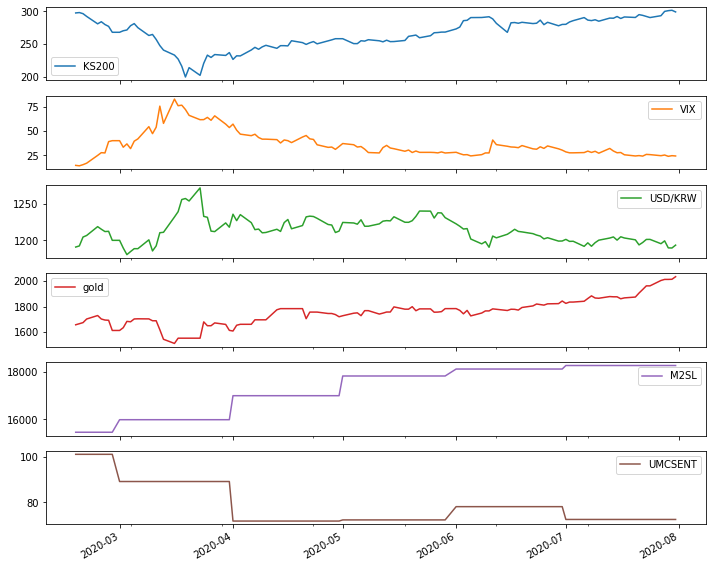

In [72]:
#데이터 시각화 
dd.plot(subplots=True, figsize=(10,8))
plt.tight_layout()
plt.show()

In [73]:
# 필요 라이브러리 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm

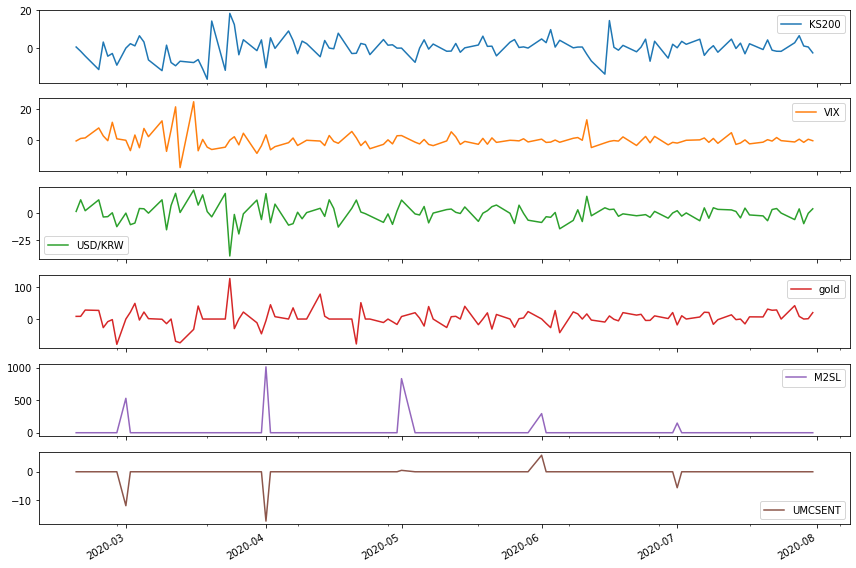

In [74]:
#차분을 이용한 추세제거 
dd.diff(1).dropna().plot(subplots=True, figsize=(12,8))
plt.tight_layout()
a = plt.show()

In [75]:
# VAR 모형적합
raw_use_return = dd.diff(1).dropna()
fit = sm.tsa.VAR(raw_use_return).fit(maxlags=2) #var2 모형 (2단위시간 전까지 값을 사용, Y_t=A1*Y_t-1+A2*Y_t-2+e_t, k=3)
display(fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, May, 2022
Time:                     00:17:46
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    29.3547
Nobs:                     117.000    HQIC:                   28.2609
Log likelihood:          -2527.62    FPE:                8.93869e+11
AIC:                      27.5133    Det(Omega_mle):     4.75038e+11
--------------------------------------------------------------------
Results for equation KS200
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.046636         0.500067           -0.093           0.926
L1.KS200          -0.280552         0.110068           -2.549           0.011
L1.VIX            -0.373198         0.117084           -3.187           

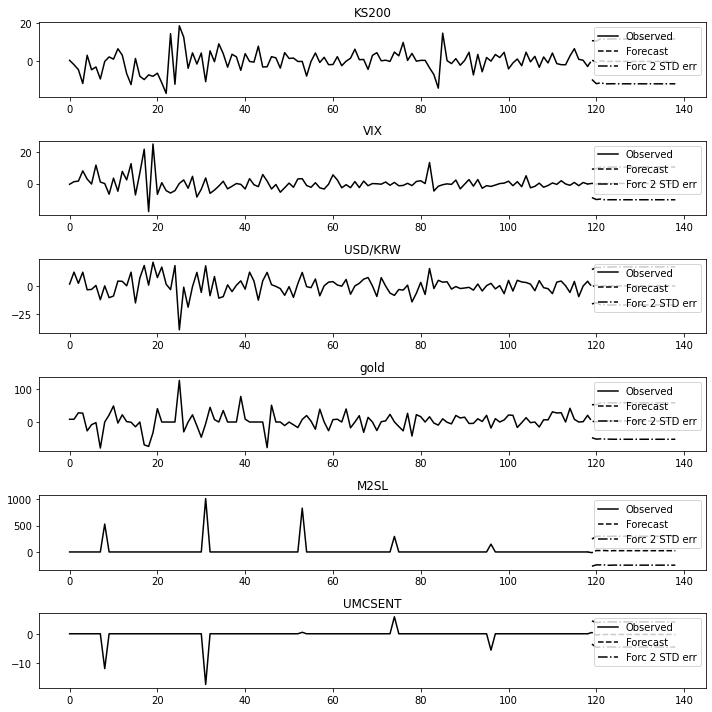

In [76]:
#예측값 확인 
forecast_num = 20
# pred_var = fit.forecast(fit.model.endog[-1:], steps=forecast_num)
# pred_var_ci = fit.forecast_interval(fit.model.endog[-1:], steps=forecast_num)

fit.plot_forecast(forecast_num) 
plt.tight_layout()
plt.show()

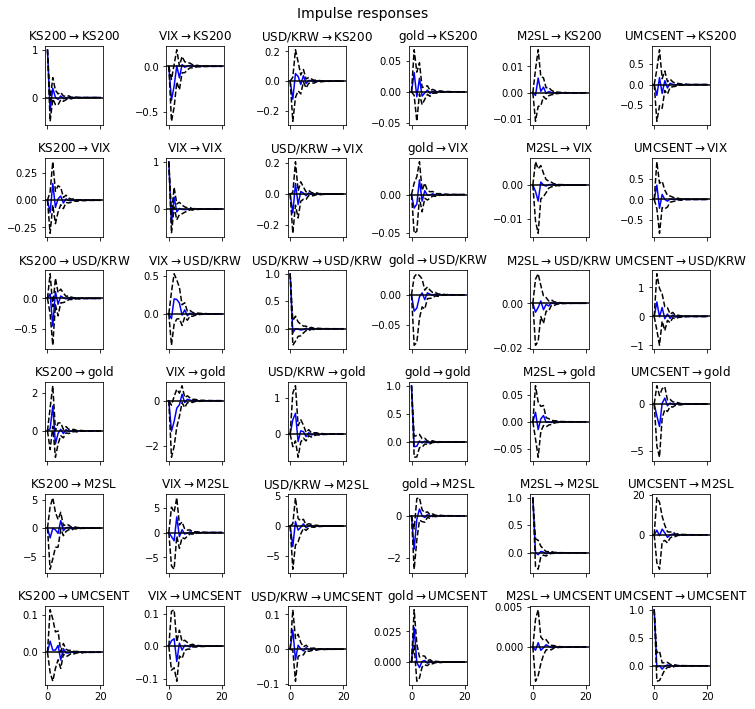

In [77]:
# 임펄스반응함수 추정
fit.irf(forecast_num).plot()
plt.tight_layout()
plt.show()

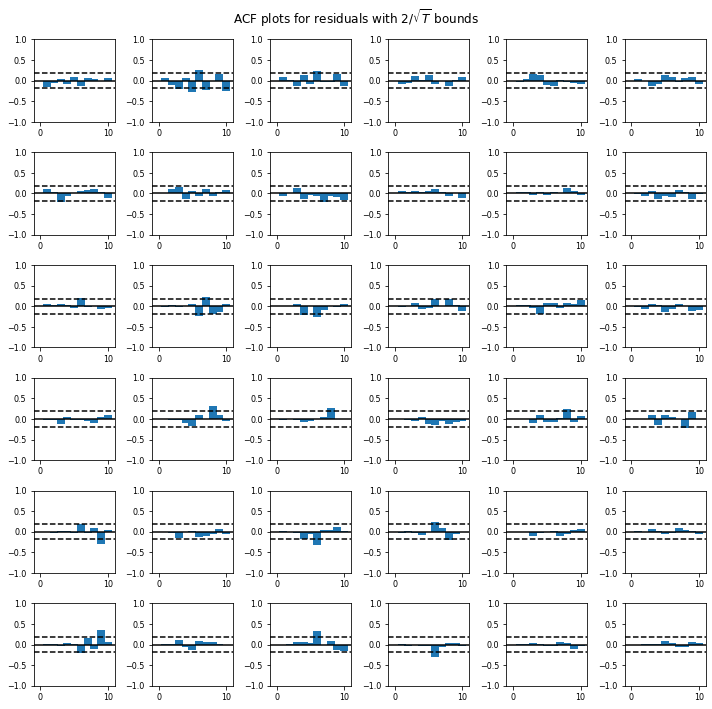

In [78]:
# 잔차진단
fit.plot_acorr()
plt.tight_layout()
plt.show()